In [1]:
import matplotlib
import matplotlib.pyplot as plt

import itertools
import random
from scipy.stats import binom
from scipy.stats import poisson
import networkx as nx
import numpy as np
import json
import os

In [2]:
# Global Constants: hg38 reference

hg38_configs = '''
@SQ	SN:chr1	LN:248956422
@SQ	SN:chr2	LN:242193529
@SQ	SN:chr3	LN:198295559
@SQ	SN:chr4	LN:190214555
@SQ	SN:chr5	LN:181538259
@SQ	SN:chr6	LN:170805979
@SQ	SN:chr7	LN:159345973
@SQ	SN:chr8	LN:145138636
@SQ	SN:chr9	LN:138394717
@SQ	SN:chr10	LN:133797422
@SQ	SN:chr11	LN:135086622
@SQ	SN:chr12	LN:133275309
@SQ	SN:chr13	LN:114364328
@SQ	SN:chr14	LN:107043718
@SQ	SN:chr15	LN:101991189
@SQ	SN:chr16	LN:90338345
@SQ	SN:chr17	LN:83257441
@SQ	SN:chr18	LN:80373285
@SQ	SN:chr19	LN:58617616
@SQ	SN:chr20	LN:64444167
@SQ	SN:chr21	LN:46709983
@SQ	SN:chr22	LN:50818468
'''

hg38_configs = [item.replace('SN:', '').replace('LN:', '').split('\t')[1:] for item in [line for line in hg38_configs.split('\n') if line != '' ]]
hg38_configs = {key: int(value) for key, value in hg38_configs}

hg38_names = list(hg38_configs.keys())
hg38_lenghts = [hg38_configs[key] for key in hg38_names]
hg38_start_end = [(1, hg38_configs[key] + 1) for key in hg38_names]
hg38_lenghts_prob = [i / sum(hg38_lenghts) for i in hg38_lenghts]


# Randomly generated copy number segements for hg38, assume there is only one segment per chrom
hg38_totalCN = [2, 3, 2, 4, 3, 4, 2, 2, 2, 4, 3, 2, 2, 4, 1, 4, 4, 4, 4, 2, 1, 2]
hg38_alCN = [(1, 1), (1, 2), (1, 1), (1, 3), (1, 2), (1, 3), (1, 1), (1, 1), (1, 1), (2, 2), (1, 2), (1, 1), (1, 1),
             (1, 3), (1, 0), (1, 3), (2, 2), (3, 1), (1, 3), (1, 1), (1, 0), (1, 1)]

chrom_size = 22

In [3]:
## generation of a guided tree
def gen_tree(n_nodes):
    good_tree = False
    while not good_tree:
        tree = nx.generators.directed.gn_graph(np.random.randint(n_nodes, n_nodes + 1)).reverse()
        if get_immediate_successors(tree) < 3: good_tree = True
    return tree

def get_immediate_successors(tree):
    """
    Get the immediate successors (children) of every node in the tree.

    Parameters:
        tree (networkx.DiGraph): Directed graph representing the tree.

    Returns:
        dict: A dictionary where keys are nodes and values are lists of immediate successors.
    """
    maxi = 0
    successors_dict = {node: list(tree.successors(node)) for node in tree.nodes}

    for node, successors in successors_dict.items():
        maxi = max(len(successors), maxi)
    
    return maxi

def nx_walk(node, tree):
    """ iterate tree in pre-order depth-first search order """
    yield node
    for child in sorted(tree.successors(node), key=lambda x: np.random.random()):
        for n in nx_walk(child, tree):
            yield n


def get_siblings(node, tree):
    try:
        return tree.successors(tree.predecessors(node)[0])
    except:
        return []


def draw_graph(tree):
    fig, axes = plt.subplots(1,1,dpi=72)
    nx.draw(tree, pos=nx.spring_layout(tree), ax=axes, with_labels=True)
    plt.show()


def simulate_purity(n_samples, purity_range):
    return [round(random.uniform(purity_range[0], purity_range[1]), 3) for _ in range(n_samples)]


def simulate_missing_rate(n_samples, missing_rate_upper_limit):
    return [round(random.uniform(0, missing_rate_upper_limit), 3) for _ in range(n_samples)]


def gen_sample_from_tree_all(tree):
    leaves = [node for node in tree.nodes() if len(list(tree.successors(node))) == 0]
    leaves_to_include = leaves
    non_zero_clusters = set(sum([list(nx_walk(x, tree.reverse())) for x in leaves_to_include], []))

    clusters = [0.] * len(tree.nodes())

    while min(np.diff(sorted(clusters))) < 0.02:
        clusters = [0.] * len(tree.nodes())
        for node in nx_walk(0, tree):
            if node in non_zero_clusters:
                if len(list(tree.predecessors(node))) == 0:  # clonal case
                    clusters[node] = 1.
                    continue

                clusters[node] = (1 - random.random()) * (clusters[list(tree.predecessors(node))[0]] - sum([clusters[x] for x in get_siblings(node, tree)]))
            else:
                continue
            # if len(tree.predecessors(node)) > 0:

    return [round(x, 2) for x in clusters]


def get_ccf_no_adj(mult, cn, alt, ref, PURITY, grid_size=101):

    ccf_space = np.linspace(0, 1, grid_size)
    ccf_dist = np.zeros(grid_size)

    for mult_1_bin_val_idx, mult_1_bin_val in enumerate(ccf_space):
        x = mult_1_bin_val * mult * PURITY / (
                    float(mult_1_bin_val) * mult * PURITY + mult_1_bin_val * (cn - mult) * PURITY + (
                        1 - mult_1_bin_val) * (cn) * PURITY + 2 * (1.0 - PURITY))
        m1_draw = binom.pmf(alt, alt + ref, x)
        ccf_dist[mult_1_bin_val_idx] = m1_draw

    ccf_dist[np.isnan(ccf_dist)] = 0.
    return ccf_dist / sum(ccf_dist)

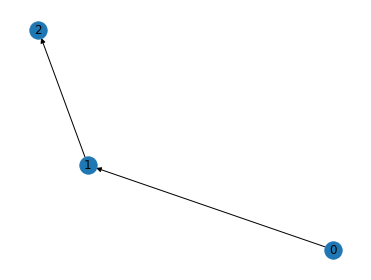

In [4]:
tree = nx.DiGraph()
# Add edges to represent the tree structure
tree.add_edges_from([
    (0, 1),  # Edge from node 0 to node 1
    (1, 2),  # Edge from node 0 to node 1
    
])
draw_graph(tree)
cluster = [
    [1.0, 0.74, 0.27],
    [1.0, 0.37, 0.03]
]

In [7]:

def run_simulation(argv, tree, clusters):
    
    n_clusters = int(argv['n_clusters'])
    n_samples = int(argv['n_samples'])
    read_depth = int(argv['read_depth'])
    
    n_mutations = int(argv['n_mutations'])
    missing_rate = float(argv['missing_rate_upper_limit'])
    purity = argv['purity']
    if purity == 'uniform':
        purity = simulate_purity(n_samples, purity_range=[0.4, 0.7])
    missing_rate = simulate_missing_rate(n_samples, missing_rate_upper_limit=missing_rate)

    output_root = argv['output_root']
    replicate = int(argv['replicate'])
    replicate += 1

    if not os.path.exists(output_root):
        os.mkdir(output_root)
    
    cn = 2.0 #ploidy of normal cells

    # good_sim = 0
    # while good_sim == 0:
    #     tree = gen_tree(n_clusters)
    #     clusters = [gen_sample_from_tree_all(tree) for x in range(max(n_samples, 2))]
    #     # Loops to check that clusters are not identical.
    #     for c_idx, clust in enumerate(np.array(clusters).T):
    #         if min(clust) < 0: continue 
    #         good_clust = 0
    #         for s_c_idx, s_clust in enumerate(np.array(clusters).T):
    #             if s_c_idx == c_idx: continue
    #             if min(s_clust) < 0: continue
    
    #             if max(np.abs(clust - s_clust)) < 0.2: break
    #         else:
    #             good_clust = 1
    
    #         if good_clust == 0: break
    
    #     else:
    #         good_sim = 1

    # ## Simulate proportions of SNVs counts in all clusters
    
    clust_props = [random.random() + 0.1 for x in sorted(clusters)[0]]
    clust_props = [ x/sum(clust_props) for x in clust_props]

    # for cluster in clusters:
    #     print(cluster)

    # draw_graph(tree)

    output_handle = open(output_root + '/simulation_data_cluster_%s_region_%s_read_depth_%s_replica_%s.tsv' % (n_clusters, n_samples, read_depth, replicate), 'w')
    _header = ['mutation', 'region', 'ref_counts', 'alt_counts', 'normal_cn', 'major_cn', 'minor_cn', 'tumour_purity', 'multiplicity', 'ccf', 'cluster']
    _header = '\t'.join(_header)
    
    output_handle.write(_header + '\n')
    
    mutation_collection = dict()
    
    for mutation_index in range(n_mutations):
        
        config_index = np.argmax(np.random.multinomial(1, hg38_lenghts_prob))

        chrom = hg38_names[config_index]
        pos = random.choice(range(1, hg38_configs[chrom] + 1))
        
        ## same mutation should have the same cluster index, but different ccf
        total_reads = poisson.rvs(read_depth, size=1).tolist()
        total_reads = total_reads[0]
        
        total_CN = hg38_totalCN[config_index] ## assume clonal CN
        al_1, al_2 = hg38_alCN[config_index]
        al_CN = [al_1, al_2]

        random.shuffle(al_CN)
        new_alCN = al_CN[0]
        if new_alCN == 0:
            new_alCN = al_CN[1]

        # Sample the multiplicity
        # _temp = range(1, new_alCN + 1)
        # _temp = [_item for _item in _temp]
        # mult = random.choice(_temp)
        mult = new_alCN
        
        cluster_index = np.argmax(np.random.multinomial(1, clust_props))
        
        for sample_index in range(n_samples):
            # Yu, 12/12/2024
            # if random.random() < missing_rate[sample_index]:
            #     ccf = 0
            # else:
            #     ccf = clusters[sample_index][cluster_index]
                
            ccf = clusters[sample_index][cluster_index]

            af = ccf * mult * purity[sample_index] / ( purity[sample_index] * total_CN + 2 * (1.0 - purity[sample_index]))
            af = round(af, 4)

            alt_reads = binom.rvs(total_reads, af, size=1).tolist()
            alt_reads = alt_reads[0]
            if af < 0.05: ## if af is too low, filter out this SNV from this region
                af = 0
                ccf = 0

            if af == 0:
                alt_reads = 0
            
            # multi_new = max([1, round(af / purity[sample_index] * (purity[sample_index] * total_CN + 2 * (1.0 - purity[sample_index])))])

            major_cn = al_1 if al_1 > al_2 else al_2
            minor_cn = al_1 if al_1 < al_2 else al_2
            
            _output = [chrom + ':' + str(pos), 'R' + str(sample_index + 1), str(total_reads - alt_reads), str(alt_reads),  str(2), str(major_cn), str(minor_cn), str(purity[sample_index]), str(mult), str(ccf), str(cluster_index)]
            _output = '\t'.join(_output)

            output_handle.write(_output + '\n')
            
    output_handle.close()


if __name__ == '__main__':

    _output_root = 'multi_clipp_simulation_data_March4'


    _argv = {
        'n_clusters': 3,
        'n_samples': 2,
        'purity': 'uniform',
        'read_depth': 100,
        'n_mutations': 100, ## the union of SNVs in all regions
        'missing_rate_upper_limit': 0.4, ## upper bound of missing rate 
        'output_root': _output_root,
        'replicate': 1
    }

    run_simulation(_argv, tree, cluster)

    # for _replica in range(10): ## replicate
    #     for _cluster in range(3, 9):
    #         for _region in range(3, 11):
    
    #             for _read_depth in [100, 500, 1000]:
    #             # if _cluster != 5 or _region != 6: 
    #             #     continue
                    
    #                 _argv = {
    #                     'n_clusters': _cluster,
    #                     'n_samples': _region,
    #                     'purity': 'uniform',
    #                     'read_depth': _read_depth,
    #                     'n_mutations': 700, ## the union of SNVs in all regions
    #                     'missing_rate_upper_limit': 0.4, ## 
    #                     'output_root': _output_root,
    #                     'replicate': _replica
    #                 }
                
    #                 run_simulation(_argv)
    

